## Part II
# Binomial Tree: option valuation (50 pts.)
 
 A commonly used approach to compute the price of an option is the so-called binomial tree method. Suppose that the maturity of an option on a non-dividend-paying stock St is divided into N subintervals of length ∆t. We will refer to the j th node at time i · ∆t as the (i, j) node. The stock price at the (i, j) node is Si,j = S0u^j * d^(i-j) (with u and d the upward and downward stock price movements, respectively). In the binomial tree approach, option prices are computed through a backward induction scheme:

1. The value of a call option at its expiration date is max{$0, S_{N,j} − K$};
2. Suppose that the values of the option at time (i + 1) · ∆t is known for all j. There is a risk-neutral probability p of moving from the (i, j) node at time i · ∆t to the (i + 1, j + 1) node at time (i + 1) · ∆t , and a probability 1 − p of moving from the (i, j) node at time i · ∆t to the (i + 1, j) node at time (i + 1) · ∆t . Risk-neutral valuation gives $f_{i,j} = e^{-r\Delta t} \left( p f_{i+1,j+1} + (1 - p) f_{i+1,j} \right)$

A general introduction to the binomial tree model and a detailed derivation of the relevant parameters is provided in appendix A. Please read the appendix carefully before starting on the assignment.

Consider a European call option on a non-dividend-paying stock with a maturity of one year and strike price of €99. Let the one year interest rate be 6% and the current price of the stock be €100. Furthermore, assume that the volatility is 20%.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm

In [37]:
def buildTree(S, vol, T, N):
    """
    Function to build the binomial tree

    Parameters
    ----------
    S : float
        Initial stock price
    vol : float
        Volatility of the stock
    T : float
        Time to maturity
    N : int
        Number of steps in the tree
    
    Returns
    -------
    matrix : np.array
        Binomial tree, with the stock price at each node
    """
    dt = T / N

    matrix = np.zeros((N + 1, N + 1))

    u = np.exp(vol * np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))
    
    for i in np.arange(N + 1):
        for j in np.arange(i + 1):
            matrix[i, j] = S * (u ** j) * (d ** (i - j))
            
    return matrix

In [38]:
sigma = 0.1
S = 80
T = 1
N = 2
buildTree(S, sigma, T, N)

array([[80.        ,  0.        ,  0.        ],
       [74.53851387, 85.86165282,  0.        ],
       [69.44987563, 80.        , 92.15279281]])

In [39]:
def valueOptionMatrix(tree, vol, T, N, r, K):
    """
    Function to value an option using the binomial tree

    Parameters
    ----------
    tree : np.array
        Binomial tree, with the stock price at each node
    vol : float
        Volatility of the stock
    T : float
        Time to maturity
    N : int
        Number of steps in the tree
    r : float
        Risk-free rate
    K : float
        Strike price
    
    Returns
    -------
    matrix : np.array
        Binomial tree, with the option value at each node
    """
    tree = tree.copy()
    
    dt = T / N

    u = np.exp(vol * np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))

    p = (np.exp(r * dt) - d) / (u - d)

    columns = tree.shape[1]
    rows = tree.shape[0]
    
    # Walk backward, we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        S = tree[rows - 1, c] # value in the matrix
        tree[rows - 1, c] = max(S - K, 0) # payoff function
    
    # For all other rows, we need to combine from previous rows
    # We walk backwards, from the last row to the first row
    for i in np.arange(rows - 1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i + 1, j]
            up = tree[i + 1, j + 1]
            # print(f"r: {r}, dt: {dt}, p: {p}, down: {down}, up: {up}")
            tree[i, j] = np.exp(-r * dt) * (p * up + (1 - p) * down)
            
    return tree

In [40]:
sigma = 0.1
S = 80
T = 1
N = 2

K = 85
r = 0.1

tree = buildTree(S, sigma, T, N)
print(f"Tree: \n{tree}")
options = valueOptionMatrix(tree, sigma, T, N, r, K)
print(f"Options: \n{options}")

Tree: 
[[80.          0.          0.        ]
 [74.53851387 85.86165282  0.        ]
 [69.44987563 80.         92.15279281]]
Options: 
[[4.61654023 0.         0.        ]
 [0.         5.74640373 0.        ]
 [0.         0.         7.15279281]]


## Question 1

In [41]:
sigma = 0.2
S = 100
T = 1
N = 50

K = 99
r = 0.06

tree = buildTree(S, sigma, T, N)
option_matrix = valueOptionMatrix(tree, sigma, T, N, r, K)
option_price_binom = option_matrix[0, 0]

print(f"Option price: €{option_price_binom:.2f}")

Option price: €11.55


# Question 2

In [42]:
def option_price_analytical(S, T, r, K, sigma):
    # Black-Scholes formula for European option prices
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

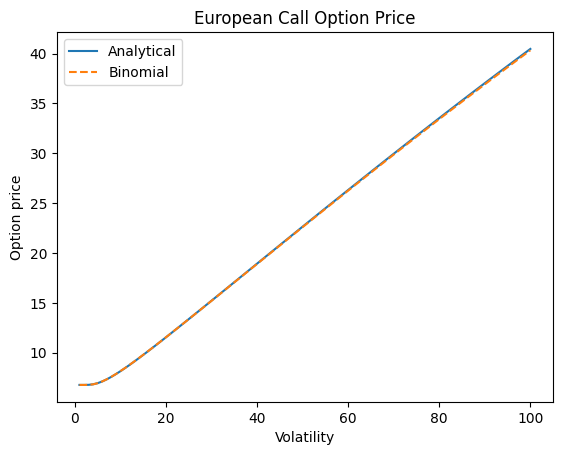

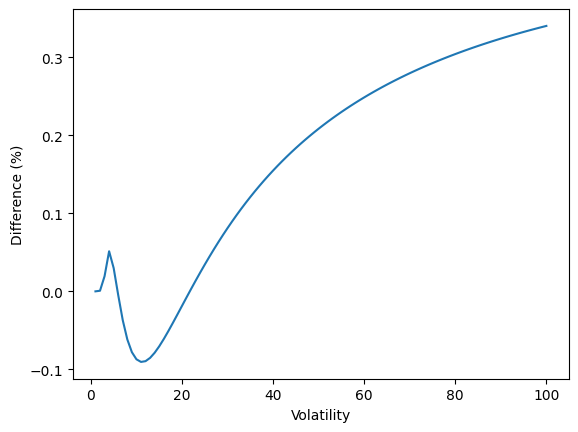

In [61]:
S = 100
T = 1
N = 50

K = 99
r = 0.06

sigma_values = np.linspace(0.01, 1, 100)

analytical_pricings = []
binomial_pricings = []

for sigma in sigma_values:
    option_price_analyt = option_price_analytical(S, T, r, K, sigma)
    tree = buildTree(S, sigma, T, N)
    option_matrix = valueOptionMatrix(tree, sigma, T, N, r, K)
    option_price_binom = option_matrix[0, 0]

    analytical_pricings.append(option_price_analyt)
    binomial_pricings.append(option_price_binom)

volatility_percentage = sigma_values * 100

# Plot the results
plt.plot(volatility_percentage, analytical_pricings, label="Analytical")
plt.plot(volatility_percentage, binomial_pricings, label="Binomial", linestyle="--")
plt.xlabel("Volatility")    
plt.ylabel("Option price")
plt.legend()
plt.title("European Call Option Price")
plt.show()

# Procentual difference
diff = (np.array(analytical_pricings) - np.array(binomial_pricings)) / np.array(analytical_pricings) * 100
plt.plot(volatility_percentage, diff)
plt.xlabel("Volatility")
plt.ylabel("Difference (%)")
plt.show()

## Question 3

100%|██████████| 299/299 [00:08<00:00, 34.94it/s] 


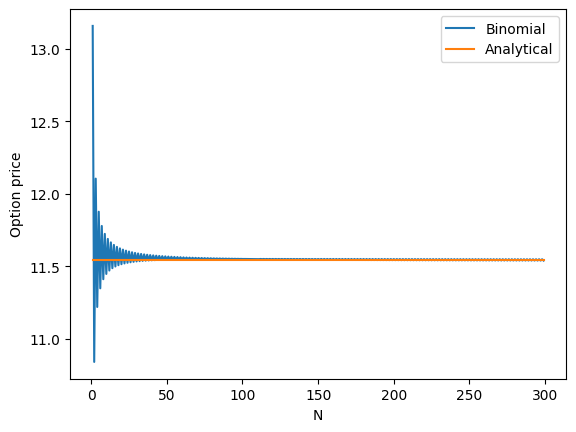

In [44]:
sigma = 0.2
S = 100
T = 1

K = 99
r = 0.06

# Play around with different ranges of N and step sizes.
N = np.arange(1, 300)

# Calculate the option price for the correct parameters
optionPriceAnalytical = option_price_analytical(S, T, r, K, sigma)

# Calculate option price for each n in N
optionPricesBinomial = []
for n in tqdm(N):
    treeN = buildTree(S, sigma, T, n)
    priceApproximatedly = valueOptionMatrix(treeN, sigma, T, n, r, K)[0, 0]
    optionPricesBinomial.append(priceApproximatedly)

# use matplotlib to plot the analytical value
# and the approximated value for each n
plt.plot(N, optionPricesBinomial, label="Binomial")
plt.plot(N, [optionPriceAnalytical] * len(N), label="Analytical")
plt.xlabel("N")
plt.ylabel("Option price")
plt.legend()
plt.show()

## Question 4

In [45]:
def delta_black_scholes(S, T, r, K, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

In [46]:
def delta_binomial(S, T, r, K, sigma, N):
    tree = buildTree(S, sigma, T, N)
    option_tree = valueOptionMatrix(tree, sigma, T, N, r, K)
    delta = (option_tree[1, 1] - option_tree[1, 0]) / (tree[1, 1] - tree[1, 0])
    return delta

In [47]:
# Test on small example
sigma = 0.1
S = 80
T = 1
N = 2

K = 85
r = 0.1

tree = buildTree(S, sigma, T, N)
print(f"Tree:\n {tree}\n")
option_tree = valueOptionMatrix(tree, sigma, T, N, r, K)
print(f"Option Tree:\n {option_tree}\n")

delta_bs = delta_black_scholes(S, T, r, K, sigma)
delta_bin = delta_binomial(S, T, r, K, sigma, N)

print(f"Delta Black-Scholes: {delta_bs:.2f}")
print(f"Delta Binomial: {delta_bin:.2f}")

Tree:
 [[80.          0.          0.        ]
 [74.53851387 85.86165282  0.        ]
 [69.44987563 80.         92.15279281]]

Option Tree:
 [[4.61654023 0.         0.        ]
 [0.         5.74640373 0.        ]
 [0.         0.         7.15279281]]

Delta Black-Scholes: 0.67
Delta Binomial: 0.51


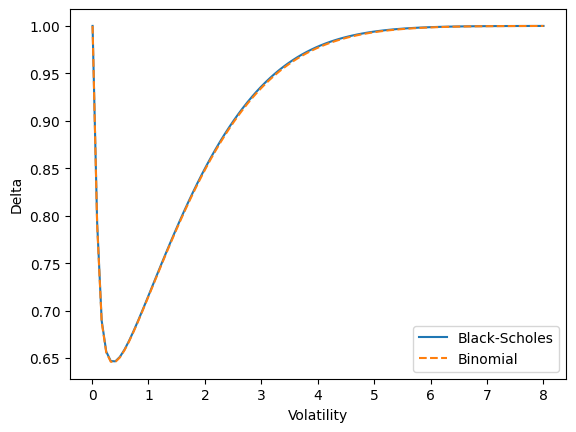

In [63]:
S = 100
T = 1
N = 50

K = 99
r = 0.06

sigma_values = np.linspace(0.01, 1, 100)

delta_bs_values = []
delta_bin_values = []

for sigma in sigma_values:
    delta_bs = delta_black_scholes(S, T, r, K, sigma)
    delta_bin = delta_binomial(S, T, r, K, sigma, N)

    delta_bs_values.append(delta_bs)
    delta_bin_values.append(delta_bin)

# Plot the results
plt.plot(sigma_values, delta_bs_values, label="Black-Scholes")
plt.plot(sigma_values, delta_bin_values, label="Binomial", linestyle="--")
plt.xlabel("Volatility")
plt.ylabel("Delta")
plt.legend()
plt.show()

## Question 5

In [49]:
# Changed function to include american option, default is european
def valueOptionMatrix(tree, vol, T, N, r, K, call=True, american=False):
    """
    Function to value an option using the binomial tree

    Parameters
    ----------
    tree : np.array
        Binomial tree, with the stock price at each node
    vol : float
        Volatility of the stock
    T : float
        Time to maturity
    N : int
        Number of steps in the tree
    r : float
        Risk-free rate
    K : float
        Strike price
    call : bool
        If the option is a call or a put (False means put option)
    american : bool
        If the option is american or european
    
    Returns
    -------
    matrix : np.array
        Binomial tree, with the option value at each node
    """
    tree = tree.copy()
    
    dt = T / N

    u = np.exp(vol * np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))

    p = (np.exp(r * dt) - d) / (u - d)

    assert p > 0 and p < 1, "p should be between 0 and 1"

    columns = tree.shape[1]
    rows = tree.shape[0]
    
    # Walk backward, we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        S = tree[rows - 1, c] # value in the matrix
        if call:
            tree[rows - 1, c] = max(S - K, 0)
        else:
            tree[rows - 1, c] = max(K - S, 0)
    
    # For all other rows, we need to combine from previous rows
    # We walk backwards, from the last row to the first row
    for i in np.arange(rows - 1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i + 1, j]
            up = tree[i + 1, j + 1]
            
            exercise_now_value = tree[i, j] - K if call else K - tree[i, j]

            # If american option, we need to check if it is better to exercise
            if american:
                tree[i, j] = max(np.exp(-r * dt) * (p * up + (1 - p) * down), exercise_now_value)
            else:
                tree[i, j] = np.exp(-r * dt) * (p * up + (1 - p) * down)
            
    return tree

In [50]:
# Example from second to last slide from BINOMIAL-MODEL.pdf lecture
sigma = 0.2
S = 50
T = 5/12.0
N = 5

K = 50
r = 0.1

tree = buildTree(S, sigma, T, N)
option_tree = valueOptionMatrix(tree, sigma, T, N, r, K, call=False, american=False)
option_tree_american = valueOptionMatrix(tree, sigma, T, N, r, K, call=False, american=True)

# Round to 2 decimals
tree = np.round(tree, 2)
option_tree = np.round(option_tree, 2)
option_tree_american = np.round(option_tree_american, 2)

print(f"Tree:\n {tree}\n")
print(f"Option Tree:\n {option_tree}\n")
print(f"Option Tree American:\n {option_tree_american}\n")

# Check if any value differs
print(f"Both option trees the same? {np.all(option_tree == option_tree_american)}")



Tree:
 [[50.    0.    0.    0.    0.    0.  ]
 [47.2  52.97  0.    0.    0.    0.  ]
 [44.55 50.   56.12  0.    0.    0.  ]
 [42.05 47.2  52.97 59.46  0.    0.  ]
 [39.69 44.55 50.   56.12 62.99  0.  ]
 [37.46 42.05 47.2  52.97 59.46 66.73]]

Option Tree:
 [[ 1.74  0.    0.    0.    0.    0.  ]
 [ 2.94  0.82  0.    0.    0.    0.  ]
 [ 4.72  1.56  0.24  0.    0.    0.  ]
 [ 7.13  2.89  0.54  0.    0.    0.  ]
 [ 9.9   5.04  1.23  0.    0.    0.  ]
 [12.54  7.95  2.8   0.    0.    0.  ]]

Option Tree American:
 [[ 1.92  0.    0.    0.    0.    0.  ]
 [ 3.3   0.85  0.    0.    0.    0.  ]
 [ 5.45  1.64  0.24  0.    0.    0.  ]
 [ 7.95  3.07  0.54  0.    0.    0.  ]
 [10.31  5.45  1.23  0.    0.    0.  ]
 [12.54  7.95  2.8   0.    0.    0.  ]]

Both option trees the same? False


In [51]:
# Example from second to last slide from BINOMIAL-MODEL.pdf lecture
sigma = 0.2
S = 50
T = 5/12.0
N = 5

K = 50
r = -0.1

tree = buildTree(S, sigma, T, N)
option_tree = valueOptionMatrix(tree, sigma, T, N, r, K, call=True, american=False)
option_tree_american = valueOptionMatrix(tree, sigma, T, N, r, K, call=True, american=True)

# Round to 2 decimals
tree = np.round(tree, 2)
option_tree = np.round(option_tree, 2)
option_tree_american = np.round(option_tree_american, 2)

print(f"Tree:\n {tree}\n")
print(f"Option Tree:\n {option_tree}\n")
print(f"Option Tree American:\n {option_tree_american}\n")

# Check if any value differs
print(f"Both option trees the same? {np.all(option_tree == option_tree_american)}")

Tree:
 [[50.    0.    0.    0.    0.    0.  ]
 [47.2  52.97  0.    0.    0.    0.  ]
 [44.55 50.   56.12  0.    0.    0.  ]
 [42.05 47.2  52.97 59.46  0.    0.  ]
 [39.69 44.55 50.   56.12 62.99  0.  ]
 [37.46 42.05 47.2  52.97 59.46 66.73]]

Option Tree:
 [[ 1.81  0.    0.    0.    0.    0.  ]
 [ 0.8   3.22  0.    0.    0.    0.  ]
 [ 0.22  1.6   5.43  0.    0.    0.  ]
 [ 0.    0.52  3.11  8.62  0.    0.  ]
 [ 0.    0.    1.24  5.7  12.57  0.  ]
 [ 0.    0.    0.    2.97  9.46 16.73]]

Option Tree American:
 [[ 1.97  0.    0.    0.    0.    0.  ]
 [ 0.83  3.54  0.    0.    0.    0.  ]
 [ 0.22  1.68  6.12  0.    0.    0.  ]
 [ 0.    0.52  3.29  9.46  0.    0.  ]
 [ 0.    0.    1.24  6.12 12.99  0.  ]
 [ 0.    0.    0.    2.97  9.46 16.73]]

Both option trees the same? False


In [52]:
# Same as before but we randomize values every time until we find a difference

while False:
    sigma = np.random.random() * 1
    S = 100
    T = np.random.random() * 100
    N = 5

    K = np.random.random() * 2 + 99
    r = np.random.random() * .5

    u = np.exp(sigma * np.sqrt(T / N))
    d = np.exp(-sigma * np.sqrt(T / N))
    p = (np.exp(r * T / N) - d) / (u - d)

    if p > 1 or p < 0:
        continue

    tree = buildTree(S, sigma, T, N)
    option_tree = valueOptionMatrix(tree, sigma, T, N, r, K, call=True, american=False)
    option_tree_american = valueOptionMatrix(tree, sigma, T, N, r, K, call=True, american=True)

    tree = np.round(tree, 2)
    option_tree = np.round(option_tree, 2)
    option_tree_american = np.round(option_tree_american, 2)

    if not np.all(option_tree == option_tree_american) and p < 1 and p > 0:
        # Round to 2 decimals
        

        print(f"Tree:\n {tree}\n")
        print(f"Option Tree European:\n {option_tree}\n")
        print(f"Option Tree American:\n {option_tree_american}\n")
        print(f"sigma: {sigma}, S: {S}, T: {T}, N: {N}, K: {K}, r: {r}, u: {np.exp(sigma * np.sqrt(T / N))}, d: {np.exp(-sigma * np.sqrt(T / N))}, p: {(np.exp(r * T / N) - np.exp(-sigma * np.sqrt(T / N))) / (np.exp(sigma * np.sqrt(T / N)) - np.exp(-sigma * np.sqrt(T / N)))}")

        print(f"European option: {option_tree[0, 0]}")
        print(f"American option: {option_tree_american[0, 0]}")
        break

In [53]:
# Parameters as given in part 2

sigma = 0.2
S = 100
T = 1
N = 50

K = 99
r = 0.06

# First as a call
tree = buildTree(S, sigma, T, N)
option_tree = valueOptionMatrix(tree, sigma, T, N, r, K, call=True, american=False)
option_tree_american = valueOptionMatrix(tree, sigma, T, N, r, K, call=True, american=True)

option_price_european = option_tree[0, 0]
option_price_american = option_tree_american[0, 0]

print(f"Call option price (European): €{option_price_european:.2f}")
print(f"Call option price (American): €{option_price_american:.2f}\n")

# Then as a put
tree = buildTree(S, sigma, T, N)
option_tree = valueOptionMatrix(tree, sigma, T, N, r, K, call=False, american=False)
option_tree_american = valueOptionMatrix(tree, sigma, T, N, r, K, call=False, american=True)

option_price_european = option_tree[0, 0]
option_price_american = option_tree_american[0, 0]

print(f"Put option price (European): €{option_price_european:.2f}")
print(f"Put option price (American): €{option_price_american:.2f}\n")

Call option price (European): €11.55
Call option price (American): €11.55

Put option price (European): €4.78
Put option price (American): €5.35



In [54]:
S = 100
T = 1
N = 50

K = 99
r = 0.06

sigma_values = np.linspace(0.01, 8, 100)

call_prices_european = []
call_prices_american = []
put_prices_european = []
put_prices_american = []

for sigma in sigma_values:
    tree = buildTree(S, sigma, T, N)
    call_option_tree = valueOptionMatrix(tree, sigma, T, N, r, K, call=True, american=False)
    call_option_tree_american = valueOptionMatrix(tree, sigma, T, N, r, K, call=True, american=True)
    call_prices_european.append(call_option_tree[0, 0])
    call_prices_american.append(call_option_tree_american[0, 0])

    put_option_tree = valueOptionMatrix(tree, sigma, T, N, r, K, call=False, american=False)
    put_option_tree_american = valueOptionMatrix(tree, sigma, T, N, r, K, call=False, american=True)
    put_prices_european.append(put_option_tree[0, 0])
    put_prices_american.append(put_option_tree_american[0, 0])

df = pd.DataFrame({
    "sigma": sigma_values,
    "sigma_percentages": sigma_values * 100, # For plotting purposes
    "call_prices_european": call_prices_european,
    "call_prices_american": call_prices_american,
    "put_prices_european": put_prices_european,
    "put_prices_american": put_prices_american
})

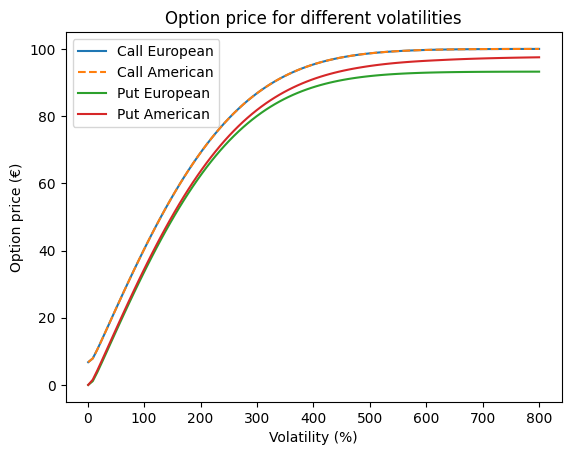

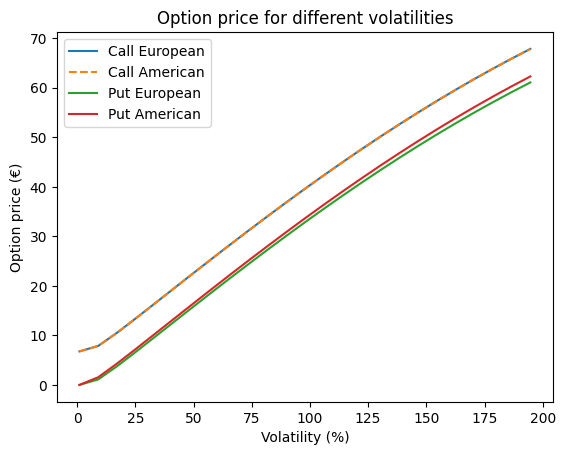

In [55]:
# Plot the results
plt.plot(df["sigma_percentages"], df["call_prices_european"], label="Call European")
plt.plot(df["sigma_percentages"], df["call_prices_american"], label="Call American", linestyle="--")
plt.plot(df["sigma_percentages"], df["put_prices_european"], label="Put European")
plt.plot(df["sigma_percentages"], df["put_prices_american"], label="Put American")
plt.xlabel("Volatility (%)")
plt.ylabel("Option price (€)")
plt.title("Option price for different volatilities")
plt.legend()
plt.show()

# Plot only until 100% volatility
df_low_end = df[df["sigma_percentages"] <= 200]
plt.plot(df_low_end["sigma_percentages"], df_low_end["call_prices_european"], label="Call European")
plt.plot(df_low_end["sigma_percentages"], df_low_end["call_prices_american"], label="Call American", linestyle="--")
plt.plot(df_low_end["sigma_percentages"], df_low_end["put_prices_european"], label="Put European")
plt.plot(df_low_end["sigma_percentages"], df_low_end["put_prices_american"], label="Put American")
plt.xlabel("Volatility (%)")
plt.ylabel("Option price (€)")
plt.title("Option price for different volatilities")
plt.legend()
plt.show()

In [56]:
S = 100
T = 1
N = 50

K = 99
r = 0.06

sigma_values = np.linspace(0.01, 1, 100)

call_prices_european = []
call_prices_american = []
put_prices_european = []
put_prices_american = []

for sigma in sigma_values:
    tree = buildTree(S, sigma, T, N)
    call_option_tree = valueOptionMatrix(tree, sigma, T, N, r, K, call=True, american=False)
    call_option_tree_american = valueOptionMatrix(tree, sigma, T, N, r, K, call=True, american=True)
    call_prices_european.append(call_option_tree[0, 0])
    call_prices_american.append(call_option_tree_american[0, 0])

    put_option_tree = valueOptionMatrix(tree, sigma, T, N, r, K, call=False, american=False)
    put_option_tree_american = valueOptionMatrix(tree, sigma, T, N, r, K, call=False, american=True)
    put_prices_european.append(put_option_tree[0, 0])
    put_prices_american.append(put_option_tree_american[0, 0])

df_detailed = pd.DataFrame({
    "sigma": sigma_values,
    "sigma_percentages": sigma_values * 100, # For plotting purposes
    "call_prices_european": call_prices_european,
    "call_prices_american": call_prices_american,
    "put_prices_european": put_prices_european,
    "put_prices_american": put_prices_american
})

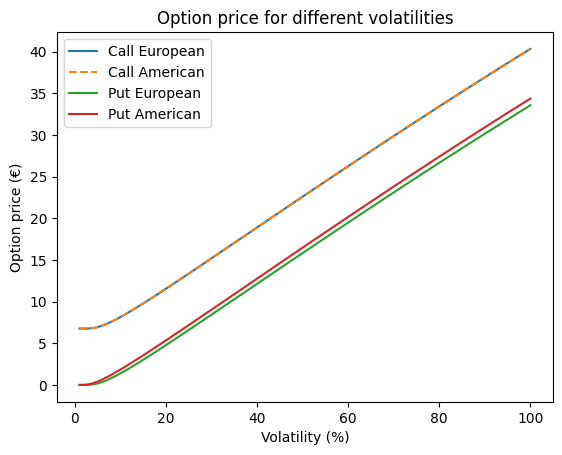

In [57]:
# Plot the results
plt.plot(df_detailed["sigma_percentages"], df_detailed["call_prices_european"], label="Call European")
plt.plot(df_detailed["sigma_percentages"], df_detailed["call_prices_american"], label="Call American", linestyle="--")
plt.plot(df_detailed["sigma_percentages"], df_detailed["put_prices_european"], label="Put European")
plt.plot(df_detailed["sigma_percentages"], df_detailed["put_prices_american"], label="Put American")
plt.xlabel("Volatility (%)")
plt.ylabel("Option price (€)")
plt.title("Option price for different volatilities")
plt.legend()
plt.show()